## Possible DarkQuest acceptance

Simple contour plots showing reach of darkquest detection of A'-> dileptons.
Depends on __rates__ (xsec * BR) files in `data` directory.

Takes as input log file from running over available mass/coupling parameter space with the following format:

```line format: n_accepted total_events mass eps min_vz max_vz Brem/Eta```


In [69]:
import math
import numpy
import os
import matplotlib.pyplot as plt
import matplotlib.colors
import matplotlib.patches as mpatches
import random as rand
 
class event:
    def __init__(self,values):
        self._acpE = int(values[0])
        self._nEv = int(values[1])
        self._mass = float(values[2])
        self._eps = float(values[3])
        self._minvz = float(values[4])
        self._maxvz = float(values[5])
        self._mech = str(values[6])
        
    def getRatio(self):
        return(self._acpE/self._nEv)
    
    def getEps(self):
        return self._eps
    
    def getMass(self):
        return self._mass
    
    def getMech(self):
        return self._mech
    
    def __repr__(self):
        return str([self._acpE,self._nEv,self._mass,self._eps,self._minvz,self._maxvz,self._mech])
    
def parseFile(minVz,maxVz,lep="muons",mech="Brem"):
    #line format: n_accepted total_events mass eps min_vz max_vz Brem/Eta 
    fileName = "data/output_%s_%i_%i.txt"%(lep,minVz,maxVz)
    file = open(fileName)
    prevLine = ""
    spStr = ""
    eventsList = []
    for l in file.readlines():
        spStr = l.split()
        newEvent = event(spStr)
        if newEvent.getMech()==mech:
            eventsList.append(newEvent)
    return eventsList

# rates: xs *BR
# assume that BR e- ~= BR muons for now
# unless Asher can give us similar files for e-
def getRate(lep="muons",mech="Brem"):
    rates = {}
    ifile = open("data/AprimeToMuonsRate_%s.txt"%mech)
    for l in ifile:
        temp = l.split()
        if 'GeV' in l: continue
        rates['%.3f'%float(temp[0])] = float(temp[1])
    return rates

def yields(minVz,maxVz,lep="muons",mech="Brem"):
    events = parseFile(minVz,maxVz,lep)
    
    # protons on target
    POT = 10**18 
    # xs*BR
    rates = getRate(lep,mech)
    
    yields = {}
    masses = []
    epsilons = []
    couplings = {}
        
    for ev in events:
        if ev.getMass() not in masses:
            masses.append(ev.getMass())
        if ev.getEps() not in epsilons:
            epsilons.append(ev.getEps())
        if ev.getEps() in couplings:
            couplings[ev.getEps()].append(ev)
        else:
            couplings[ev.getEps()]=[ev]

    
    # remove masses for which we dont have rates
    new_masses = []
    for m in masses:
        newm = '%.3f'%m
        if lep=='muons':
            if newm in rates.keys():
                new_masses.append(m)
            #else:
            #    print('no rate for %s'%newm)
                
        if lep=='electrons':
            if newm not in rates.keys():
                if (m > 0.25 and m < 3.05 and mech=='Brem') or (m > 0.25 and m < 0.55 and mech=='Eta'):
                    new_masses.append(m)
                    #print('no rate for %s'%newm,round(m, 1),round(m*2,2)/2)
                    rates[newm] = rates['%.3f'%float(round(m*2,2)/2)]
            else:
                new_masses.append(m)
                #print('rate for %s'%newm,round(m, 1))
   

    masses = new_masses
    cross = []
    i=0
    for eps in epsilons:
        cross.append([])
        for m in masses:
            for ev in events:
                if ev.getMass() == m and ev.getEps() == eps:
                    cross[i].append(ev.getRatio()*POT*rates['%.3f'%m]*eps**2)
        i+=1
        
    # now plot
    fig = plt.figure()
    ax = fig.add_subplot(1,1,1)
    CS = ax.contour(masses, epsilons, cross,levels=1000,cmap = "viridis")
    ax.set_xlabel("mass (GeV)")
    ax.set_ylabel(r"$\epsilon$")
    ax.set_title(r'Acceptance*POT*$\epsilon^{2}$*XS*BR %s %i %i'%(mech,minVz,maxVz))
    ax.set_yscale('log')
    if lep=='muons':
        if 'Brem' in mech:
            ax.set_xlim(.25,3.05)
            ax.set_xscale('log')
        else:
            ax.set_xlim(.25,.55)
    if lep=='electrons':
        if 'Brem' in mech:
            ax.set_xlim(.001,3.05)
            ax.set_xscale('log')
        else:
            ax.set_xlim(.001,1.5) 
            ax.set_xscale('log')
    plt.colorbar(CS)
    plt.show()
    plt.savefig("yield_%s_%s.png"%(lep,mech))
    plt.clf()

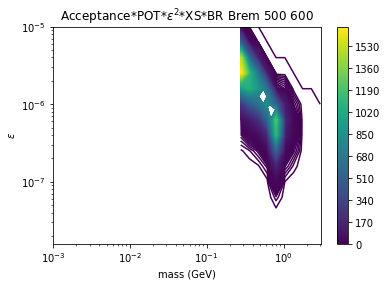

<Figure size 432x288 with 0 Axes>

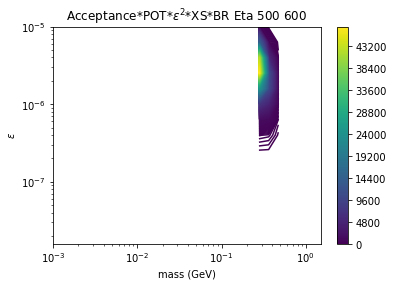

<Figure size 432x288 with 0 Axes>

In [68]:
yields(500,600,"electrons","Brem")
yields(500,600,"electrons","Eta")

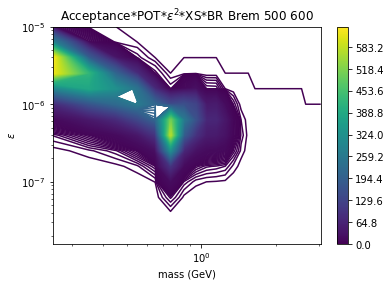

<Figure size 432x288 with 0 Axes>

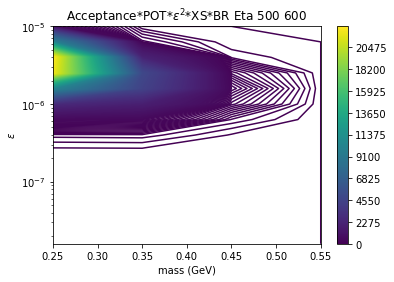

<Figure size 432x288 with 0 Axes>

In [70]:
yields(500,600,"muons","Brem")
yields(500,600,"muons","Eta")